**Goal:** To build a predictive model to predict the winning probability of teams during the final match of IPL Season 2017

Since the predictability of winning the final match in Season 2017 depends mainly on the compositions of the teams and their performances in Season 2017, we will consider only the Season 2017's data. 

In [150]:
from IPython import get_ipython
get_ipython().magic('reset -sf') 

import operator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_columns', 100)

In [151]:
# read the input files and look at the top few lines #
data_path = "/Users/venkatasravankanukolanu/Documents/Data Files/ipl/"
match= pd.read_csv(data_path+"matches.csv")
score= pd.read_csv(data_path+"deliveries.csv")

In [165]:
match_df=match[(match['season']==2017) & (match['dl_applied']==0)]
match_df.head()

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN
1,2,2017,Pune,2017-04-06,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN
2,3,2017,Rajkot,2017-04-07,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,10,CA Lynn,Saurashtra Cricket Association Stadium,Nitin Menon,CK Nandan,NaN
3,4,2017,Indore,2017-04-08,Rising Pune Supergiant,Kings XI Punjab,Kings XI Punjab,field,normal,0,Kings XI Punjab,0,6,GJ Maxwell,Holkar Cricket Stadium,AK Chaudhary,C Shamshuddin,NaN
4,5,2017,Bangalore,2017-04-08,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,15,0,KM Jadhav,M Chinnaswamy Stadium,NaN,NaN,NaN


Since "id" from "match_df" and match_id from score_df are common columns, we can join "season" with score_df to subset for delivary level data from Season 2017

In [153]:
score_df=score.merge(match_df[['id','season','winner']],left_on='match_id',right_on='id', how='inner')
score_df.head()

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,wide_runs,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder,id,season,winner
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1,2017,Sunrisers Hyderabad
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1,2017,Sunrisers Hyderabad
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,4,0,4,NaN,NaN,NaN,1,2017,Sunrisers Hyderabad
3,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1,2017,Sunrisers Hyderabad
4,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,DA Warner,S Dhawan,TS Mills,0,2,0,0,0,0,0,2,2,NaN,NaN,NaN,1,2017,Sunrisers Hyderabad


Now we need to think about the features that are required to build the model. To get started, will list the features in 2 different sets i.e. features that are important and features that are good to add. We can change them as we keep analyzing.

1. Runs scored in a given over
2. Wickets taken in a given over
3. Cumulative score by each over
4. Cumulative wickets taken by each over
5. Target that the team is chasing down
6. Remaining target by each over
7. Run rate
8. Required run rate
9. Difference between run rate and required run rate
10. Binary variables on whether the team for which we are predicting is batting team or bowling team
11. Total runs in the last 5 overs
12. Totals wickets in the last 5 overs

In [154]:
# Runs scored and wickets taken per over #
score_df.player_dismissed.fillna(0, inplace=True)
score_df['player_dismissed'].ix[score_df['player_dismissed'] != 0] = 1
train_df=score_df.groupby(['match_id','inning','over','batting_team','bowling_team','winner'])[['total_runs', 'player_dismissed']].agg(['sum']).reset_index()
train_df.columns=[['match_id','innings','over','batting_team','bowling_team','winner','runs_over','wkts_over']]
# Cumulative score and cumulative wickets taken by each over
train_df['innings_wickets'] = train_df.groupby(['match_id', 'innings'])['wkts_over'].cumsum()
train_df['innings_score'] = train_df.groupby(['match_id', 'innings'])['runs_over'].cumsum()

/Users/venkatasravankanukolanu/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


,match_id,innings,over,batting_team,bowling_team,winner,runs_over,wkts_over,innings_wickets,innings_score
0,1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,7,0,0,7
1,1,1,2,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,16,1,1,23
2,1,1,3,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,6,0,1,29
3,1,1,4,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,4,0,1,33
4,1,1,5,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,9,0,1,42


In [155]:
# Target that the team is chasing down. if first innings, target is -1#
score_inning1=train_df.groupby(['match_id','innings','batting_team','bowling_team'])['runs_over'].sum().reset_index()
score_inning1['innings']=np.where(score_inning1['innings']==1,2,1)
train_df=train_df.merge(score_inning1,how='left',on=['match_id', 'innings'])
train_df=train_df.drop(['batting_team_y', 'bowling_team_y'],axis=1)
train_df.columns=['match_id','innings','over','batting_team','bowling_team','winner','runs_over','wkts_over','innings_wkts','innings_runs','target']
first_innings_index = train_df[train_df.loc[:,'innings'] == 1].index
train_df.loc[first_innings_index, "target"] = -1
#train_df.head(40)

In [156]:
# Remaining target that the team is chasing down. if first innings, remaining target is -1#
train_df['remaining_target']=train_df['target']-train_df['innings_runs']
train_df.loc[first_innings_index, "remaining_target"] = -1
#train_df.head(40)

In [157]:
#Run rate
train_df['run_rate']=train_df['innings_runs']/train_df['over']
train_df.head()

,match_id,innings,over,batting_team,bowling_team,winner,runs_over,wkts_over,innings_wkts,innings_runs,target,remaining_target,run_rate
0,1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,7,0,0,7,-1.0,-1.0,7.000000
1,1,1,2,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,16,1,1,23,-1.0,-1.0,11.500000
2,1,1,3,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,6,0,1,29,-1.0,-1.0,9.666667
3,1,1,4,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,4,0,1,33,-1.0,-1.0,8.250000
4,1,1,5,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,9,0,1,42,-1.0,-1.0,8.400000
5,1,1,6,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,17,0,1,59,-1.0,-1.0,9.833333
6,1,1,7,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,5,0,1,64,-1.0,-1.0,9.142857
7,1,1,8,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,11,0,1,75,-1.0,-1.0,9.375000
8,1,1,9,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,9,0,1,84,-1.0,-1.0,9.333333
9,1,1,10,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,4,0,1,88,-1.0,-1.0,8.800000


In [158]:
# Required run rate. If first innings, required run rate is -1. If 20th over, equired run rate is 99 #
def get_required_rr(row):
    if row['remaining_target'] == -1:
        return -1.
    elif row['over'] == 20:
        return 99
    else:
        return row['remaining_target'] / (20-row['over'])
    
train_df['required_run_rate'] = train_df.apply(lambda row: get_required_rr(row), axis=1)

In [159]:
#Difference in run rate and required run rate. If first innings, it is -1#
def get_rr_diff(row):
    if row['innings'] == 1:
        return -1
    else:
        return row['run_rate'] - row['required_run_rate']
    
train_df['runrate_diff'] = train_df.apply(lambda row: get_rr_diff(row), axis=1)

In [160]:
#Response. If batting team is winner, set 1 elseif bowling_team is winner, set 0 #
#train_df['is_batting_team'] = (train_df['team1'] == train_df['batting_team']).astype('int')
train_df['is_batting_winner'] = (train_df['batting_team'] == train_df['winner']).astype('int')
train_df.head()

,match_id,innings,over,batting_team,bowling_team,winner,runs_over,wkts_over,innings_wkts,innings_runs,target,remaining_target,run_rate,required_run_rate,runrate_diff,is_batting_winner
0,1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,7,0,0,7,-1.0,-1.0,7.000000,-1.0,-1.0,1
1,1,1,2,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,16,1,1,23,-1.0,-1.0,11.500000,-1.0,-1.0,1
2,1,1,3,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,6,0,1,29,-1.0,-1.0,9.666667,-1.0,-1.0,1
3,1,1,4,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,4,0,1,33,-1.0,-1.0,8.250000,-1.0,-1.0,1
4,1,1,5,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,9,0,1,42,-1.0,-1.0,8.400000,-1.0,-1.0,1


### Function to train a Xgboost model

In [170]:
x_cols = ['innings', 'over', 'runs_over', 'wkts_over', 'innings_wkts', 'innings_runs', 'target', 'remaining_target', 'run_rate', 'required_run_rate', 'runrate_diff']
# let us take all the matches but for the final as development sample and final as val sample #
val_df = train_df.ix[train_df.match_id == 59,:]
dev_df = train_df.ix[train_df.match_id != 59,:]

# create the input and target variables #
dev_X = np.array(dev_df[x_cols[:]])
dev_y = np.array(dev_df['is_batting_winner'])
val_X = np.array(val_df[x_cols[:]])[:-1,:]
val_y = np.array(val_df['is_batting_winner'])[:-1]
print(dev_X.shape, dev_y.shape)
print(val_X.shape, val_y.shape)

((2225, 11), (2225,))
((39, 11), (39,))


In [168]:
# define the function to create the model #
def runXGB(train_X, train_y, seed_val=0):
    param = {}
    param['objective'] = 'binary:logistic'
    param['eta'] = 0.05
    param['max_depth'] = 8
    param['silent'] = 1
    param['eval_metric'] = "auc"
    param['min_child_weight'] = 1
    param['subsample'] = 0.7
    param['colsample_bytree'] = 0.7
    param['seed'] = seed_val
    num_rounds = 100

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)
    model = xgb.train(plst, xgtrain, num_rounds)
    return model

In [176]:
# let us build the model and get predcition for the final match #
model = runXGB(dev_X, dev_y)
xgtest = xgb.DMatrix(val_X)
preds = model.predict(xgtest)

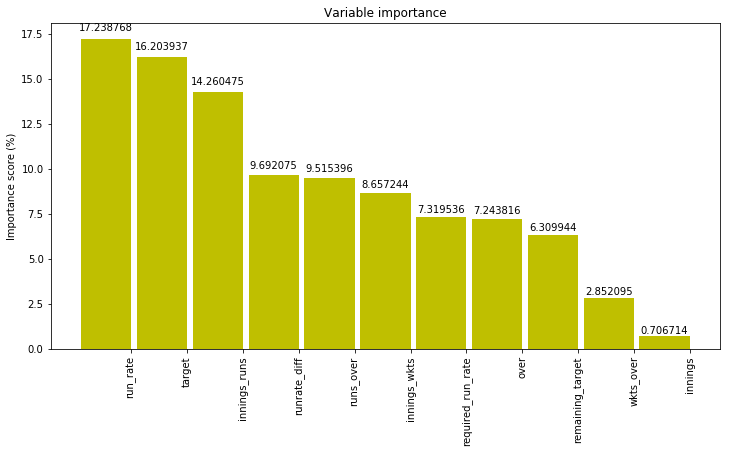

In [181]:
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i,feat))
    outfile.close()

create_feature_map(x_cols)
importance = model.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1), reverse=True)
imp_df = pd.DataFrame(importance, columns=['feature','fscore'])
imp_df['fscore'] = (imp_df['fscore'] / imp_df['fscore'].sum())*100

# create a function for labeling #
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.02*height,
                '%f' % float(height),
                ha='center', va='bottom')
        
labels = np.array(imp_df.feature.values)
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(12,6))
rects = ax.bar(ind, np.array(imp_df.fscore.values), width=width, color='y')
ax.set_xticks(ind+((width)/2.))
ax.set_xticklabels(labels, rotation='vertical')
ax.set_ylabel("Importance score (%)")
ax.set_title("Variable importance")
autolabel(rects)
plt.show()